## Install torch-geometric and other required packages

In [0]:
!pip install torch-scatter==latest+cu101 torch-sparse==latest+cu101 -f https://s3.eu-central-1.amazonaws.com/pytorch-geometric.com/whl/torch-1.4.0.html
!pip install torch-geometric

Looking in links: https://s3.eu-central-1.amazonaws.com/pytorch-geometric.com/whl/torch-1.4.0.html
  Using cached https://s3.eu-central-1.amazonaws.com/pytorch-geometric.com/whl/torch-1.4.0/torch_scatter-latest%2Bcu101-cp36-cp36m-linux_x86_64.whl
  Using cached https://s3.eu-central-1.amazonaws.com/pytorch-geometric.com/whl/torch-1.4.0/torch_sparse-latest%2Bcu101-cp36-cp36m-linux_x86_64.whl
  Found existing installation: torch-scatter 2.0.4
    Uninstalling torch-scatter-2.0.4:
      Successfully uninstalled torch-scatter-2.0.4
  Found existing installation: torch-sparse 0.6.0
    Uninstalling torch-sparse-0.6.0:
      Successfully uninstalled torch-sparse-0.6.0


## Package Initialization

In [0]:
import numpy as np

import math

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

## Upload training data to Google Colab VM

In [2]:
# upload training and testing data
from google.colab import files

uploaded = files.upload()

Saving 0.txt to 0.txt
Saving 0_score.txt to 0_score.txt
Saving 1.txt to 1.txt
Saving 1_score.txt to 1_score.txt


In [3]:
!ls

0_score.txt  0.txt  1_score.txt  1.txt	sample_data


## process training data and targets

In [0]:
# function to get torch_geometric.data.Data object from sythnetic graph
def get_synthetic_data(number = 0):

    # read network file
    edges = []
    with open(str(number) + ".txt", "r") as file:
        lines = file.readlines();

        for line in lines:
            if len(line) == 0:
                continue
            edge = line.split("\t")
            edge[0] = int(edge[0])
            edge[1] = int(edge[1])
            edges.append(edge)

        edges= torch.tensor(np.array(edges), dtype=torch.long)

    # read node score file
    node_scores = []
    with open("0_score.txt", "r") as file:
        lines = file.readlines();

        for line in lines:
            if len(line) == 0:
                continue
            sequences = line.split("\t")
            node_scores.append(float(sequences[1]))

        node_scores = torch.tensor(np.array(node_scores), dtype=torch.float)

    return (edges, node_scores)

In [0]:
edges, node_scores = get_synthetic_data(0)

In [6]:
print(edges)
print(node_scores)

tensor([[   0,    4],
        [   0,    5],
        [   0,    8],
        ...,
        [4844, 4849],
        [4870, 4928],
        [4937, 4953]])
tensor([9.4175e-02, 5.3971e-02, 4.4344e-02,  ..., 1.9542e-05, 6.0578e-05,
        1.0908e-04])


## Compute every node's degree

In [0]:
node_number = node_scores.size()[0]

In [0]:
degrees = []
degrees_dict = {}

for edge in edges:
    for node in edge:
        str_index = str(node.item())
        if str_index not in degrees_dict:
            degrees_dict[str_index] = 1
        elif degrees_dict[str_index] >= 1:
            degrees_dict[str_index] += 1

for i in range(node_number):
    degrees.append(degrees_dict[str(i)])

degrees = torch.Tensor(np.array(degrees))
degrees_dict = None


In [10]:
degrees.size()

torch.Size([5000])

## Define DrBC Network

In [0]:
class DrBCNetwork(nn.Module):
    def __init__(self, input_dimension = 3, embedding_dimension = 128):
        super(DrBCNetwork, self).__init__()

        self.input_dimension = input_dimension
        self.embedding_dimension = embedding_dimension
        self.linear1 = nn.Linear(self.input_dimension, self.embedding_dimension, bias=False)
        self.gru_cell1 = nn.GRUCell(self.embedding_dimension, self.embedding_dimension, bias=False)
        self.gru_cell2 = nn.GRUCell(self.embedding_dimension, self.embedding_dimension, bias=False)
        self.linear2 = nn.Linear(self.embedding_dimension, int(self.embedding_dimension / 2), bias=False)
        self.linear3 = nn.Linear(int(self.embedding_dimension / 2), 1, bias=False)

        # aggregation weights look-up table
        sqrt_degrees = degrees.sqrt()
        self.aggregation_weights = torch.zeros([node_number, node_number], dtype=torch.float32)
        for i in range(node_number):
            if i % 500 == 0:
                print("calculating aggregation weights: {}/{}".format(i, node_number))
            for j in range(i):
                self.aggregation_weights[i, j] = 1 / (sqrt_degrees[i].item()*sqrt_degrees[j].item() + 1e-7)

        # make it diagonal symmetry matrix
        self.aggregation_weights = self.aggregation_weights.T + self.aggregation_weights
        sqrt_degrees = None
        
        # node neighborhood look-up table
        self.neighborhood = torch.zeros([node_number, node_number], dtype=torch.bool)
        for edge in edges:
            source, target = edge
            self.neighborhood[source.item(), target.item()] = self.neighborhood[target.item(), source.item()] = 1

    
    def forward(self, x):

        # Encoding
        # ============================================================================================

        # x's shape: [node_number, 3] --> use all node without batching

        h0 = x
        h1 = F.normalize(F.relu(self.linear1(h0))) # h1: [node_number, embedding_dimension]

        # neighborhood aggregation: layer 2
        h2n =  torch.mm(self.neighborhood * self.aggregation_weights, h1) # h2n: [node_number, embedding_dimension]
        
        # combination: layer 2
        h2 = self.gru_cell1(h2n, h1) # h2: [node_number, embedding_dimenstion]

        # normalize the embedding vector
        h2 = F.normalize(h2)

        # neighborhood aggregation: layer 3
        h3n = torch.mm(self.neighborhood * self.aggregation_weights, h2) # h3n: [node_number, embedding_dimension]
        
        # combination: layer 3
        h3 = self.gru_cell2(h3n, h2) # h3: [node_number, embedding_dimenstion]

        # normalize the embedding vector
        h3 = F.normalize(h3)

        # layer aggregation: element-wise max pooling
        z = torch.max(torch.max(h1, h2), h3)

        # Decoding
        # ===========================================================================================

        # 1-st fully-connected
        z = self.linear2(z)
        z = F.relu(z)

        z = self.linear3(z)

        return z
        

## Define Loss Function

In [0]:
class PairwiseRankingLoss(nn.Module):
    def __init__(self, sample_number):
        super(PairwiseRankingLoss, self).__init__()
        self.sample_number = sample_number
        
    def forward(self, outputs, targets):

        errors = torch.zeros([self.sample_number])

        # draw samples from prediction outputs and targets
        for i in range(self.sample_number):
            perm = torch.randperm(outputs.size(0))
            index = perm[:2]
            y_diff = outputs[index][0].item() - outputs[index][1].item()
            b_diff = targets[index][0].item() - targets[index][1].item()

            errors[i] = (-1) * self.sigmoid(b_diff) * math.log( self.sigmoid(y_diff) ) - (1 - self.sigmoid(b_diff)) * math.log(1 - self.sigmoid(y_diff))

        return torch.sum(errors)

    def sigmoid(self, x):
        return (1 / (1 + math.exp( -1 * x )))

In [0]:
def SoftmaxLoss(outputs, targets):
    # softmax
    return torch.sum(torch.abs(F.softmax(outputs, dim=0) - F.softmax(targets, dim=0)))

## Training

In [0]:
# constants
LEARNING_RATE = 0.0001
EPOCHS = 100

In [29]:
# create network object
drbc = DrBCNetwork(input_dimension=3)

calculating aggregation weights: 0/5000
calculating aggregation weights: 500/5000
calculating aggregation weights: 1000/5000
calculating aggregation weights: 1500/5000
calculating aggregation weights: 2000/5000
calculating aggregation weights: 2500/5000
calculating aggregation weights: 3000/5000
calculating aggregation weights: 3500/5000
calculating aggregation weights: 4000/5000
calculating aggregation weights: 4500/5000


In [0]:
# create optimizer (Adam used)
optimizer = optim.Adam(drbc.parameters(), lr=LEARNING_RATE)

In [16]:
# prepare data x
x = torch.ones([node_number, 3])
for i in range(node_number):
    x[i][0] = degrees[i]

x[:3]

tensor([[239.,   1.,   1.],
        [178.,   1.,   1.],
        [149.,   1.,   1.]])

In [34]:
history = torch.zeros([EPOCHS])
for i in range(EPOCHS):

    optimizer.zero_grad()   # zero the gradient buffers
    z = drbc(x)
    loss = SoftmaxLoss(z, node_scores.unsqueeze(1))
    print("Loss: {}".format(loss))
    history[i] = loss
    loss.backward()
    optimizer.step()

Loss: 0.003818470984697342
Loss: 0.0028907391242682934
Loss: 0.0021071620285511017
Loss: 0.001522190636023879
Loss: 0.001190211740322411
Loss: 0.0010881501948460937
Loss: 0.0011098162503913045
Loss: 0.0011260474566370249
Loss: 0.0010669832117855549
Loss: 0.0009470422519370914
Loss: 0.0008201384916901588
Loss: 0.0007215249352157116
Loss: 0.0006566948140971363
Loss: 0.0006286623538471758
Loss: 0.0006289605516940355
Loss: 0.0006239519570954144
Loss: 0.0005826819688081741
Loss: 0.000513772014528513
Loss: 0.0004512725572567433
Loss: 0.0004318689461797476
Loss: 0.0004648250760510564
Loss: 0.0004541001981124282
Loss: 0.00041481287917122245
Loss: 0.0004101405502296984
Loss: 0.0004296363622415811
Loss: 0.00043649409781210124
Loss: 0.0004267124750185758
Loss: 0.00040762737626209855
Loss: 0.0003905317571479827
Loss: 0.00039178982842713594
Loss: 0.00039211075636558235
Loss: 0.00037089307443238795
Loss: 0.0003598705807235092
Loss: 0.0003579215263016522
Loss: 0.0003545053186826408
Loss: 0.0003461950

plot the errors

In [0]:
import matplotlib
import matplotlib.pyplot as plt

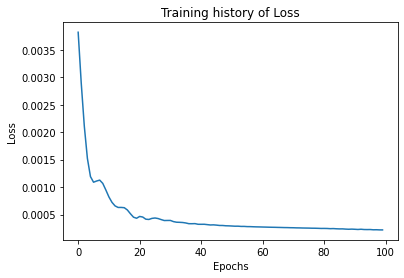

In [40]:

plt.plot(history.detach().numpy())
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training history of Loss")
plt.show()

## Discussion
* How to handle if graph is highly dynamic (nodes' degrees change frequently)